In [1]:
import PSILOGIT
import numpy as np
from PSILOGIT.tools import *
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

# Experiments for Section 6.1

### First example with a small selection event. $p=20, \lambda=1.5, n=10$

In [123]:
model = PSILOGIT.PSILOGIT(np.ones(20), 1.5,  n=10)
print('Size of the set of active variables: ', len(model.M))
nbM_admissibles, ls_states_admissibles = model.compute_selection_event(compare_with_energy=True)
print('Size of the selection event: ', len(ls_states_admissibles))

3


In [125]:
def linear_temperature(t):
    return 0.2/np.log(t+1)

states, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=50000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)

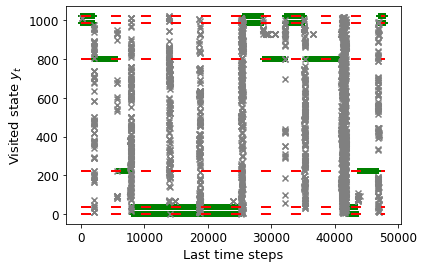

In [126]:
model.last_visited_states(states, ls_states_admissibles)

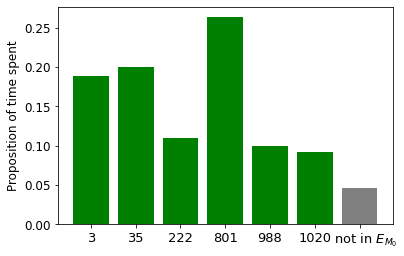

In [128]:
model.histo_time_in_selection_event(states, ls_states_admissibles)

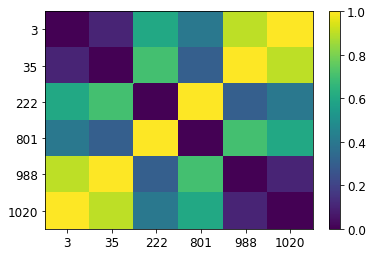

In [129]:
q = len(ls_states_admissibles)
cov = np.zeros((q,q))
for i in range(q):
    for j in range(q):
        cov[i,j] = np.sum(np.array(ls_states_admissibles[i])!=np.array(ls_states_admissibles[j])) / model.X.shape[0]
fig, ax = plt.subplots()
heatmap = ax.pcolor(cov)

#legend
cbar = plt.colorbar(heatmap)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(cov.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cov.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

#labels
column_labels = [int(fy) for fy in nbM_admissibles]
row_labels = column_labels
ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

### Second example with a larger selection event. $p=15, \lambda=2, n=10$

In [6]:
model = PSILOGIT.PSILOGIT(np.zeros(15), 2,  n=10)
print('Size of the set of active variables: ', len(model.M))

def linear_temperature(t):
    return 0.2/np.log(t+1)

states, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=100000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)
nbM_admissibles, ls_states_admissibles = model.compute_selection_event(compare_with_energy=True)
print('Size of the selection event: ', len(ls_states_admissibles))

Size of the set of active variables:  2


  0%|          | 0/100000 [00:00<?, ?it/s]

Size of the selection event:  22


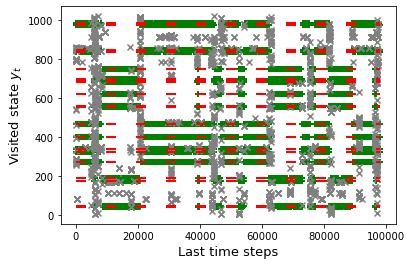

In [10]:
model.last_visited_states(states, ls_states_admissibles)

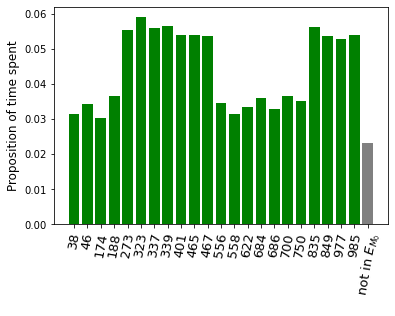

In [9]:
model.histo_time_in_selection_event(states, ls_states_admissibles, rotation_angle=80)

# Calibration of the SIGLE methods

In [28]:
## CHOOSE THE REGULARIZATION PARAMETER
lamb = 0.5

model = PSILOGIT.PSILOGIT(np.zeros(10), lamb, n=100)
print('Size of the set of active variables: ', len(model.M))
states = model.SEI_by_sampling(model.sig, nb_ite=100000)
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
if np.max(np.abs(signull-model.sig))<1e-3:
    statesnull = np.copy(states)
else:
    statesnull = model.SEI_by_sampling(signull, nb_ite=100000)
tildeGN12, barpi = model.params_saturated(signull, statesnull)
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(states, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, 
                                                    calibrated_from_samples=False, statesnull=statesnull)
gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay_1 = model.pval_taylor(states, thetanull=thetanull, gamma=gamma)
lspvals_tay_Bon = model.pval_taylor(states, thetanull=thetanull, mode='Bonferroni')
lspvals_naive = model.pval_weak_learner(statesnull, states, barpi, signull=signull)
lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ['Weak learner', "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = states, sigalt=model.sig)

Size of the set of active variables:  8


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Power analysis: Setting 1
### Localized and Disseminated alternatives

In [ ]:
## CHOOSE THE SIGNAL STRENGTH
nu = 0.0

## CHOOSE THE MODE (LOCALIZED OR DISSEMINATED)
modes = ['disseminated-signal' ,'localized-signal']
mode = modes[0]

## CHOOSE THE NUMBER OF STEP FOR THE REJECTION SAMPLING METHOD 
## (for the results presented in the paper, we used nb_ite=3 000 000)
nb_ite = 10000


if mode=='localized-signal':
    vartheta = np.zeros(10)
    vartheta[0] = nu
else:
    vartheta = nu*np.ones(10)

model = PSILOGIT.PSILOGIT(vartheta, 5, n=100)
print('Size of the set of active variables: ', len(model.M))
states = model.SEI_by_sampling(model.sig, nb_ite=nb_ite)
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
if np.max(np.abs(signull-model.sig))<1e-3:
    statesnull = np.copy(states)
else:
    statesnull = model.SEI_by_sampling(signull, nb_ite=nb_ite)
tildeGN12, barpi = model.params_saturated(signull, statesnull)
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(states, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, statesnull=statesnull)
gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay_1 = model.pval_taylor(states, thetanull=thetanull, gamma=gamma)
lspvals_tay_Bon = model.pval_taylor(states, thetanull=thetanull, mode='Bonferroni')
lspvals_naive = model.pval_weak_learner(statesnull, states, barpi, signull=signull)
lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ['Weak learner', "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = states, sigalt=model.sig)

### Code to reproduce the figure of the paper presenting the power with respect to the signal strength $\nu$: To run on a cluster !

In [2]:
assert False, 'Comment the first assertion if we are aware that this portion of code will take several hours to be completely executed. Create beforehand a folder "data" at the root.'
modes = ['disseminated-signal' ,'localized-signal']
mode = modes[0]

if mode=='localized-signal':
    lsnu = [round(0.1*i,2) for i in range(0,11)]
else:
    lsnu =  [round(0.02*i,2) for i in range(0,16)]
    
    
for nu in lsnu:
    theta = nu * np.ones(10)
    model = PSILOGIT.PSILOGIT(theta, 5, n=100)
    print('Size of the set of active variables: ', len(model.M))
    print('nu: ', nu)
    states = model.SEI_by_sampling(model.sig, nb_ite=3000000)
    np.save('data/states-n100-p10-lamb5-nu'+str(nu)+'.npy',states)

names = ['Weak learner', "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']

power = np.zeros((len(lsnu),len(names)))
for idxnu, nu in enumerate(lsnu):
    if mode=='localized-signal':
        vartheta = np.zeros(10)
        vartheta[0]=nu
    else:
        vartheta = nu*np.ones(10)
    model = PSILOGIT.PSILOGIT(vartheta, 5, n=100)
    print('Size of the set of active variables: ', len(model.M))
    print('nu: ', nu)
    if mode == 'localized-signal':
        states = np.load('data/states-1coor-n100-p10-lamb5-nu'+str(nu)+'.npy')
    else:
        states = np.load('data/states-n100-p10-lamb5-nu'+str(nu)+'.npy')
    states = states
    thetanull = np.zeros(model.X.shape[1])
    signull = sigmoid(model.X @ thetanull)
    if mode == 'localized-signal':
        statesnull = np.load('data/states-1coor-n100-p10-lamb5-nu0.0.npy')
    else:
        statesnull = np.load('data/states-n100-p10-lamb5-nu0.0.npy')
    tildeGN12, barpi = model.params_saturated(signull, statesnull)

    lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(states, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, statesnull=statesnull)

    gamma = np.zeros(len(model.M))
    gamma[0] = 1
    lspvals_tay_1 = model.pval_taylor(states, thetanull=thetanull, gamma=gamma)
    lspvals_tay_Bon = model.pval_taylor(states, thetanull=thetanull, mode='Bonferroni')
    lspvals_naive = model.pval_weak_learner(statesnull, states, barpi, signull=signull)

    lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
    power[idxnu,:] = model.compute_power(lists_pvalues, names, states = states, sigalt=model.sig)

if mode == 'localized-signal':
    np.save('data/1coor-n100-p10-lamb5-power-nu.npy',power)
else:
    np.save('data/n100-p10-lamb5-power-nu.npy',power)

for j,name in enumerate(np.array(names)):
    plt.plot(lsnu, power[:,j], label=name)
if mode=='localized-signal':
    plt.xlabel('$\\nu$ such that $\\vartheta^*=[\\nu,0, ..., 0]$', fontsize=14)
else:
    plt.xlabel('$\\nu$ such that $\\vartheta^*=[\\nu, ..., \\nu]$', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.legend()
plt.savefig('data/n100-p10-lamb5-power_nu.png', dpi=300)
plt.show()

Size of the set of active variables:  4
nu:  0.0


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

Size of the set of active variables:  3
nu:  0.02


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

Size of the set of active variables:  5
nu:  0.04


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/1310 [00:00<?, ?it/s]

Size of the set of active variables:  4
nu:  0.06


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3050 [00:00<?, ?it/s]

Size of the set of active variables:  4
nu:  0.08


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3176 [00:00<?, ?it/s]

Size of the set of active variables:  4
nu:  0.1


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

Size of the set of active variables:  3
nu:  0.12


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/8184 [00:00<?, ?it/s]

Size of the set of active variables:  3
nu:  0.14


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/7911 [00:00<?, ?it/s]

Size of the set of active variables:  6
nu:  0.16


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2619 [00:00<?, ?it/s]

Size of the set of active variables:  6
nu:  0.18


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3337 [00:00<?, ?it/s]

Size of the set of active variables:  6
nu:  0.2


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

Size of the set of active variables:  7
nu:  0.22


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2558 [00:00<?, ?it/s]

Size of the set of active variables:  7
nu:  0.24


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/3346 [00:00<?, ?it/s]

Size of the set of active variables:  7
nu:  0.26


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

Size of the set of active variables:  7
nu:  0.28


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/5233 [00:00<?, ?it/s]

Size of the set of active variables:  7
nu:  0.3


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/6381 [00:00<?, ?it/s]

### Code to generate states from the SEI-SLR algorithm in the Setting 2: Running this cell will take 20 minutes.

In [ ]:
model = PSILOGIT.PSILOGIT(np.ones(20), 2,  n=15)
print(len(model.M))

def linear_temperature(t):
    return 0.2/np.log(t+1)**2
def b(x):
    return (1-np.sqrt(np.min([-x/0.009, 1])))

states, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=1000000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)
np.save('data/states-n15-p20-lamb2-SEI.npy',states)
np.save('data/energies-n15-p20-lamb2-SEI.npy',energies)
np.save('data/ls_FNR-n15-p20-lamb2-SEI.npy',ls_FNR)

# Experiments for Section 6.3.3

In [60]:
model = PSILOGIT.PSILOGIT(np.zeros(20), 3,  n=15)
print(len(model.M))
def linear_temperature(t):
    return 0.2/np.log(t+1)

nbM_admissibles, ls_statesnull_admissibles = model.compute_selection_event(compare_with_energy=True)
len(ls_statesnull_admissibles)
#statesnull, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=50000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)

1


940

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

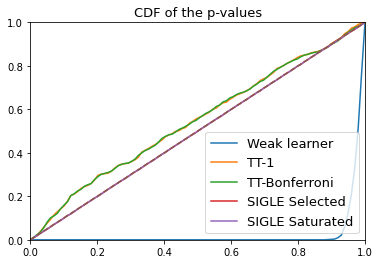

In [61]:
ls_states_admissibles = np.copy(ls_statesnull_admissibles)
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
tildeGN12, barpi = model.params_saturated(signull, ls_statesnull_admissibles)
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(ls_states_admissibles, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, signull=signull, statesnull=ls_statesnull_admissibles)
gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay_1 = model.pval_taylor(ls_states_admissibles, thetanull=thetanull, gamma=gamma)
lspvals_tay_Bon = model.pval_taylor(ls_states_admissibles, thetanull=thetanull, mode='Bonferroni')
lspvals_naive = model.pval_weak_learner(ls_statesnull_admissibles, ls_states_admissibles, barpi, signull=signull)
lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ["Weak learner",  "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = ls_states_admissibles, sigalt=model.sig, figname='null-n15-p20-lamb3.png')

In [67]:
theta = np.zeros(20)
theta[0] = 1
#0.15*np.ones(20)
model = PSILOGIT.PSILOGIT(theta, 3,  n=15)
print(model.M)
def linear_temperature(t):
    return 0.2/np.log(t+1)

nbM_admissibles, ls_states_admissibles = model.compute_selection_event(compare_with_energy=True)
len(ls_states_admissibles)
# states, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=50000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)

[3]


938

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

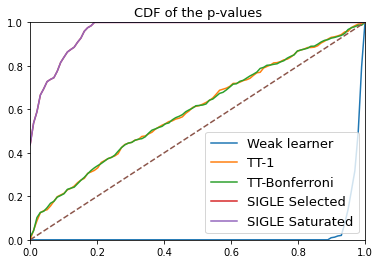

In [68]:
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
tildeGN12, barpi = model.params_saturated(signull, ls_statesnull_admissibles)
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(ls_states_admissibles, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, signull=signull, statesnull=ls_statesnull_admissibles)
gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay_1 = model.pval_taylor(ls_states_admissibles, thetanull=thetanull, gamma=gamma)
lspvals_tay_Bon = model.pval_taylor(ls_states_admissibles, thetanull=thetanull, mode='Bonferroni')
lspvals_naive = model.pval_weak_learner(ls_statesnull_admissibles, ls_states_admissibles, barpi, signull=signull)
lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ["Weak learner",  "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = ls_states_admissibles, sigalt=model.sig, figname='local-alt0p15-n15-p20-lamb3.png')

# Experiments for Section 6.3.5

#### a) Under the null

In [49]:
model_size2 = PSILOGIT.PSILOGIT(0*np.ones(5), 7, n=100)
print('Size of the selection event: ', len(model_size2.M))

signull = 0.5 * np.ones(model_size2.X.shape[0])

Size of the selection event:  2


In [50]:
states2 = model_size2.SEI_by_sampling(model_size2.sig, nb_ite=100000)
print(len(states2))
statesnull = model_size2.SEI_by_sampling(signull, nb_ite=100000)
tildeGN12, barpi = model_size2.params_saturated(signull, statesnull)

  0%|          | 0/100000 [00:00<?, ?it/s]

1662


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/1662 [00:00<?, ?it/s]

Proportion in the ellipse :  0.9494584837545126
Proportion outside of the ellipse :  0.05054151624548736


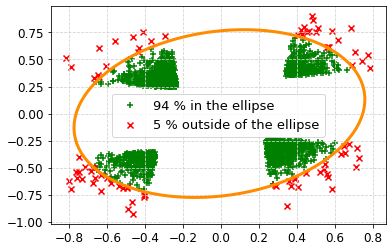

In [51]:
model_size2.ellipse_testing(states2, barpi, alpha=0.05, figname='data/null-ellipse.png', grad_descent={'lr':0.01,'return_gaps':True,'max_ite':5000}, calibrated_from_samples=True, statesnull=statesnull, l2_regularization=100000)

#### b) Under the alternative

In [119]:
theta = np.zeros(10)
theta[0] = 0.5
model_size2 = PSILOGIT.PSILOGIT(theta, 8, n=100)
print('Size of the selection event: ', len(model_size2.M))

signull = 0.5 * np.ones(model_size2.X.shape[0])

Size of the selection event:  2


In [120]:
states2 = model_size2.SEI_by_sampling(model_size2.sig, nb_ite=100000)
print(len(states2))
statesnull = model_size2.SEI_by_sampling(signull, nb_ite=100000)
tildeGN12, barpi = model_size2.params_saturated(signull, statesnull)

  0%|          | 0/100000 [00:00<?, ?it/s]

3210


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Proportion in the ellipse :  0.7514018691588785
Proportion outside of the ellipse :  0.2485981308411215


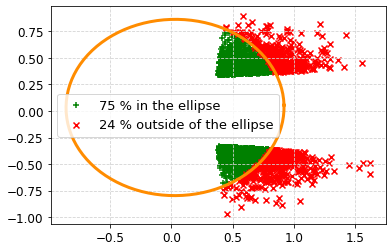

In [122]:
model_size2.ellipse_testing(states2, barpi, alpha=0.05, figname='data/alt-ellipse-1p5-lamb8.png', grad_descent={'lr':0.01,'return_gaps':True,'max_ite':5000}, calibrated_from_samples=True, statesnull=statesnull, l2_regularization=100000)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

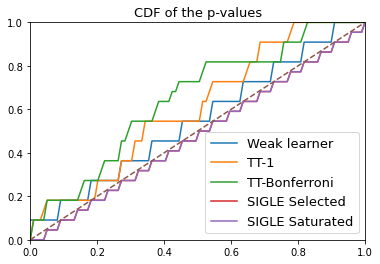

In [34]:
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(ls_statesnull_admissibles, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, signull=signull, statesnull=ls_statesnull_admissibles)

lspvals_tay_1 = model.pval_taylor(ls_statesnull_admissibles, thetanull=thetanull, gamma=gamma)
lspvals_tay_Bon = model.pval_taylor(ls_statesnull_admissibles, thetanull=thetanull, mode='Bonferroni')
lspvals_naive = model.pval_weak_learner(ls_statesnull_admissibles, ls_statesnull_admissibles, barpi, signull=signull)
lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ['Weak learner', "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = ls_statesnull_admissibles, sigalt=model.sig, figname='null-n10-p15-lamb2.png')

In [19]:
model_size2.ellipse_testing(ls_states_admissibles, barpi, alpha=0.05, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':5000}, calibrated_from_samples=True, statesnull=ls_statesnull_admissibles, l2_regularization=100000)

0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456
0.3912045615933456


In [29]:
probas = [compute_proba(ls_states_admissibles[i], model.sig) for i in range(len(ls_states_admissibles))]
probas /= np.sum(probas)

idxs = np.random.choice([i for i in range(len(ls_states_admissibles))], size=3000, p=probas)
states = np.array([ls_states_admissibles[i] for i in idxs])

idxs = np.random.choice([i for i in range(len(ls_states_admissibles))], size=3000)
statesnull = np.array([ls_states_admissibles[i] for i in idxs])

thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
tildeGN12, barpi = model.params_saturated(signull, statesnull)

In [27]:
states

array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

##### a) $n>>p$ under the null

In [ ]:
idxs = np.where(energies<1e-3)[0]
fy_EM = list(set([binary_encoding(states[i]) for i in idxs]))
EM_states = np.array([binary_encoding_inv(fy, model.X.shape[0]) for fy in fy_EM])
probas = [compute_proba(EM_states[i], model.sig) for i in range(len(EM_states))]
probas /= np.sum(probas)

idxs = np.random.choice([i for i in range(len(EM_states))], size=1000, p=probas)
states = np.array([EM_states[i] for i in idxs])

idxs = np.random.choice([i for i in range(len(EM_states))], size=1000)
statesnull = np.array([EM_states[i] for i in idxs])

thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
tildeGN12, barpi = model.params_saturated(signull, statesnull)

In [ ]:
model = PSILOGIT.PSILOGIT(np.zeros(10), 5, n=100)
print('Size of the set of active variables: ', len(model.M))

In [30]:
states = model.SEI_by_sampling(model.sig, nb_ite=1000000)
print(len(states))
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
if np.max(np.abs(signull-model.sig))>1e-3:
    statesnull = model.SEI_by_sampling(signull, nb_ite=100000)
else:
    statesnull = np.copy(states)
tildeGN12, barpi = model.params_saturated(signull, statesnull)

  0%|          | 0/1000000 [00:00<?, ?it/s]

774


  0%|          | 0/774 [00:00<?, ?it/s]

In [31]:
np.save('states-p10-lamb5-n100-null.npy',states)

In [32]:
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(states, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, statesnull=statesnull)

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

In [33]:
gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay_1 = model.pval_taylor(states, thetanull=thetanull, gamma=gamma)

lspvals_tay_SM = model.pval_taylor(states, thetanull=thetanull, mode='lasso-signs')

lspvals_tay_Bon = model.pval_taylor(states, thetanull=thetanull, mode='Bonferroni')

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

In [34]:
lspvals_naive = model.pval_weak_learner(statesnull, states, barpi, signull=signull)

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

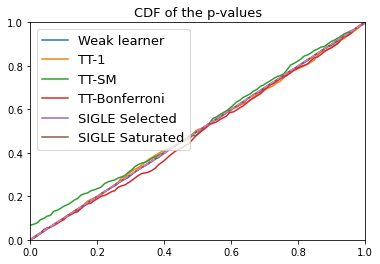

In [36]:
#lists_pvalues = [lspvals_naive, lspvals_tay, lspvals_selec, lspvals_sat]
#names = ['Weak learner', "Taylor & Tibshirani '18", 'SIGLE Selected', 'SIGLE Saturated']
lists_pvalues = [lspvals_naive, lspvals_tay_1,lspvals_tay_SM, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ['Weak learner', "TT-1", 'TT-SM', 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = states, sigalt=model.sig, figname='n100-p10-lamb5-null.png')

(array([17., 19., 16., 12., 19., 14., 26., 15., 12., 23.]),
 array([0.02517427, 0.12265684, 0.22013941, 0.31762199, 0.41510456,
        0.51258713, 0.61006971, 0.70755228, 0.80503485, 0.90251743,
        1.        ]),
 <BarContainer object of 10 artists>)

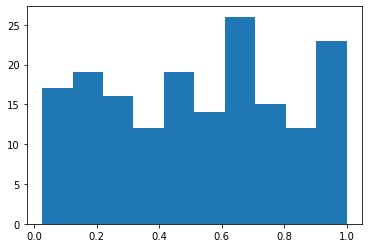

In [13]:
plt.hist(1-lspvals_tay_Bon)

##### b) $n>>p$ under the alternative

Size of the set of active variables:  4
2380


  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

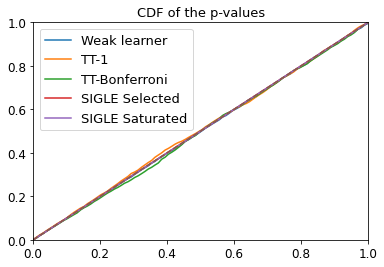

In [16]:
nu = 0.0
vartheta = np.zeros(10)
vartheta[0] = nu
model = PSILOGIT.PSILOGIT(vartheta, 5, n=100)
print('Size of the set of active variables: ', len(model.M))

states = np.load('data/states-1coor-n100-p10-lamb5-nu'+str(nu)+'.npy')

# states = np.load('data/states-n100-p10-lamb5-nu0.03.npy')
# states = model.SEI_by_sampling(model.sig, nb_ite=100000)

print(len(states))
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
# statesnull = model.SEI_by_sampling(signull, nb_ite=100000)
# statesnull = np.load('data/states-n100-p10-lamb5-nu0.0.npy')
statesnull = np.load('data/states-1coor-n100-p10-lamb5-nu0.0.npy')

tildeGN12, barpi = model.params_saturated(signull, statesnull)

lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(states, barpi, l2_regularization=100000, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000}, calibrated_from_samples=True, statesnull=statesnull)

gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay_1 = model.pval_taylor(states, thetanull=thetanull, gamma=gamma)
lspvals_tay_SM = model.pval_taylor(states, thetanull=thetanull, mode='lasso-signs')
lspvals_tay_Bon = model.pval_taylor(states, thetanull=thetanull, mode='Bonferroni')
lspvals_naive = model.pval_weak_learner(statesnull, states, barpi, signull=signull)

lists_pvalues = [lspvals_naive, lspvals_tay_1, lspvals_tay_Bon, lspvals_selec, lspvals_sat]
names = ['Weak learner', "TT-1", 'TT-Bonferroni', 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = states, sigalt=model.sig, figname='data/1coor-n100-p10-lamb5-nu'+str(nu)+'.png')

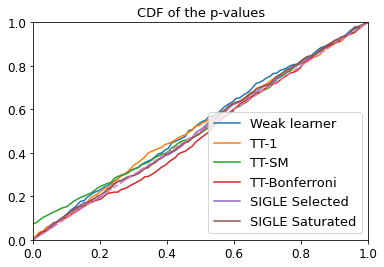

In [90]:
model.plot_cdf_pvalues(lists_pvalues, names, states = states, sigalt=model.sig, figname='data/1coor-n100-p10-nu01.png')

#### c) $p>>n$ and the null

In [17]:
model = PSILOGIT.PSILOGIT(np.zeros(60), 1, n=40)
print('Size of the set of active variables: ', len(model.M))

Size of the set of active variables:  22


In [13]:
nbM_admissibles, ls_states_admissibles = model.compute_selection_event(compare_with_energy=True, delta=0.009)

AssertionError: 

#### c) Same experiments with $p=4$

Size of the selection event:  2


  0%|          | 0/10000 [00:00<?, ?it/s]

470


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

Proportion in the ellipse :  0.9765957446808511
Proportion outside of the ellipse :  0.023404255319148935


NameError: name 'name_figsave' is not defined

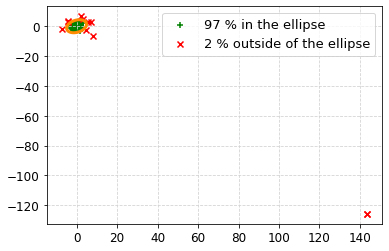

In [43]:
model_size2 = PSILOGIT.PSILOGIT(0*np.ones(4), 1, n=15)
print('Size of the selection event: ', len(model_size2.M))

signull = 0.5 * np.ones(model_size2.X.shape[0])
states2 = model_size2.SEI_by_sampling(model_size2.sig, nb_ite=10000)
print(len(states2))
statesnull = model_size2.SEI_by_sampling(signull, nb_ite=10000)
tildeGN12, barpi = model_size2.params_saturated(signull, states2)
model_size2.ellipse_testing(states2, barpi, alpha=0.05, figname='null-ellipse-p4.png', grad_descent={'lr':0.01,'return_gaps':True,'max_ite':5000}, calibrated_from_samples=True, statesnull=statesnull, l2_regularization=100000)

In [44]:
model_size2 = PSILOGIT.PSILOGIT(0.3*np.ones(4), 1.5, n=15)
print('Size of the selection event: ', len(model_size2.M))

signull = 0.5 * np.ones(model_size2.X.shape[0])
states2 = model_size2.SEI_by_sampling(model_size2.sig, nb_ite=10000)
print(len(states2))
statesnull = model_size2.SEI_by_sampling(signull, nb_ite=10000)
tildeGN12, barpi = model_size2.params_saturated(signull, states2)
model_size2.ellipse_testing(states2, barpi, alpha=0.05, figname='alt-ellipse-p4.png', grad_descent={'lr':0.01,'return_gaps':True,'max_ite':5000}, calibrated_from_samples=True, statesnull=statesnull, l2_regularization=100000)

Size of the selection event:  2


  0%|          | 0/10000 [00:00<?, ?it/s]

1155


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
model = PSILOGIT.PSILOGIT(np.ones(5), 1, n=10)

In [3]:
model.M

array([0, 2, 4], dtype=int64)

In [4]:
nbM_admissibles, ls_states_admissibles = model.compute_selection_event(compare_with_energy=True)
print(len(ls_states_admissibles))

34


In [25]:
def linear_temperature(t):
    return 0.18/np.log(t+1)
states, ls_FNR = model.SEI_SLR(total_length_SEISLR_path=300000, backup_start_time=2,  temperature=linear_temperature, repulsing_force=True, random_start=False, conditioning_signs=False, seed=10)

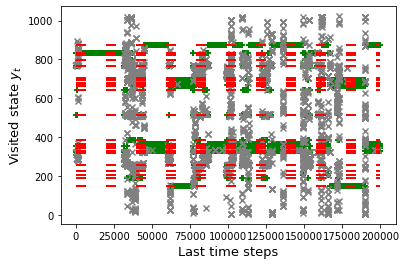

In [26]:
model.last_visited_states(states[100000:], ls_states_admissibles, figname='SEI-SLR') #, figname='SEISLR-path-15.png')

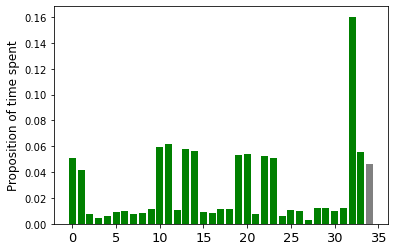

In [29]:
model.histo_time_in_selection_event(states, ls_states_admissibles, gather_states=False, show_ticks=False)

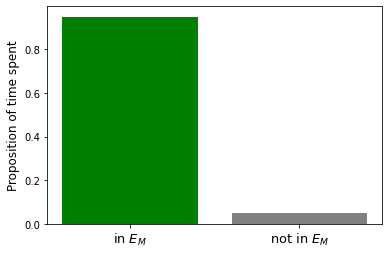

In [28]:
model.histo_time_in_selection_event(states, ls_states_admissibles, gather_states=True)

In [28]:
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
statesnull = model.SEI_by_sampling(signull, nb_ite=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
tildeGN12, barpi = model.params_saturated(signull, statesnull)

  0%|          | 0/17 [00:00<?, ?it/s]

In [30]:
lspvals_selec, lspvals_sat, gaps = model.pval_SIGLE(states, barpi, l2_regularization=10, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':100}, calibrated_from_samples=True, statesnull=statesnull)

  0%|          | 0/49997 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [32]:
gamma = np.zeros(len(model.M))
gamma[0] = 1
lspvals_tay = model.pval_taylor(states[:100], thetanull=thetanull, gamma=gamma)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
lspvals_naive = model.pval_weak_learner(statesnull, states, barpi, signull=np.zeros(model.X.shape[0]))

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/49997 [00:00<?, ?it/s]

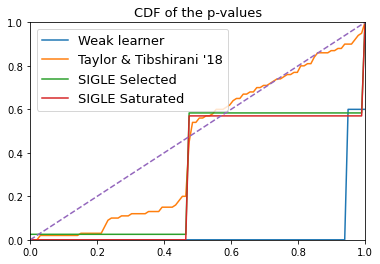

In [34]:
lists_pvalues = [lspvals_naive, lspvals_tay, lspvals_selec, lspvals_sat]
names = ['Weak learner', "Taylor & Tibshirani '18", 'SIGLE Selected', 'SIGLE Saturated']
model.plot_cdf_pvalues(lists_pvalues, names, states = states, sigalt=model.sig, figname=None)

In [11]:
model = PSILOGIT.PSILOGIT(np.ones(15), 1, n=15)

In [12]:
nbM_admissibles, ls_states_admissibles = model.compute_selection_event(compare_with_energy=True, delta=0.5)

In [13]:
len(ls_states_admissibles)

8

In [14]:
len(model.M)

4

In [19]:

def linear_temperature(t):
    return 1/np.log(t+1)**3
def b(x):
    return (1-np.sqrt(np.min([-x/0.009, 1])))

states, ls_FNR = model.SEI_SLR(total_length_SEISLR_path=20000, backup_start_time=15000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)


# for i in range(10):
#     states_ls, ls_FNR = model.SEI_SLR(total_length_SEISLR_path=5000, backup_start_time=3000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=i+2)
#     M = LogisticRegression(penalty='l1', C = 1/model.lamb, solver='liblinear', fit_intercept=False)
#     M.fit(model.X, states_ls[-1])
#     theta_hat = M.coef_[0]
#     p = model.X.shape[1]
#     sig_hat = sigmoid(model.X @ theta_hat)
#     complementM = [i for i in range(p) if i not in model.M]


#     # We set the sign the vector that best suits the KKT constraints
#     S = np.clip(model.X.T @ (states_ls[-1]-sig_hat) / model.lamb, -1, 1)
#     p1y = np.sum(1 - np.abs(S[model.M]))/len(model.M)
#     p2y = b(np.max(np.abs(S[complementM]))-1)
#     E = (np.max([0, p1y, p2y]))
#     print(E)
#     if E<1e-3:
#         states = np.vstack((states,states_ls))

C:\Users\qduch\OneDrive\Pictures\SIGLE\package\PSILOGIT\Sampling.py:210: RuntimeWarning: overflow encountered in exp
  if min(1-np.exp(- deltaE / T) , (1-old_energy*(old_energy>1e-3))) <= np.random.rand():


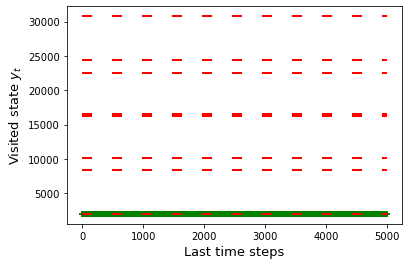

In [20]:
model.last_visited_states(states, ls_states_admissibles) #  figname='SEISLR-path.png')

In [19]:
binary_encoding(states[575])

752

In [20]:

y = states[575]
M = LogisticRegression(penalty='l1', C = 1/model.lamb, solver='liblinear', fit_intercept=False)
M.fit(model.X, y)
theta_hat = M.coef_[0]
p = model.X.shape[1]
sig_hat = sigmoid(model.X @ theta_hat)
complementM = [i for i in range(p) if i not in model.M]


# We set the sign the vector that best suits the KKT constraints
S = np.clip(model.X.T @ (y-sig_hat) / model.lamb, -1, 1)
p1y = np.sum(1 - np.abs(S[model.M]))/len(model.M)
p2y = b(np.max(np.abs(S[complementM]))-1)
E = (np.max([0, p1y, p2y]))
print(E)

0.010039444615687843


In [38]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

selected_states = []
def b(x):
    return (1-np.sqrt(np.min([-x/0.009, 1])))
n,p = model.X.shape
complement_XT = model.X[:,[k for k in range(p) if k not in model.M]].T
complementM = [i for i in range(p) if i not in model.M]
count = 0
for y in states[33000:35000]:

    M = LogisticRegression(penalty='l1', C = 1/model.lamb, solver='liblinear', fit_intercept=False)
    M.fit(model.X, y)
    theta_hat = M.coef_[0]
    sig_hat = sigmoid(model.X @ theta_hat)

    # We set the sign the vector that best suits the KKT constraints
    S = np.clip(model.X.T @ (y-sig_hat) / model.lamb, -1, 1)
    p1y = np.sum(1 - np.abs(S[model.M]))/len(model.M)
    p2y = b(np.max(np.abs(S[complementM]))-1)
    E = (np.max([0, p1y, p2y]))
    print(E)
    for yin in ls_states_admissibles:
        if (y== yin).all():
            print('IN')
            count +=1
    if E<1e-3:
        selected_states.append(y)
            
print(count/len(states))


1.0
1.0
0.9802611433837443
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9146488835105477
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9821226128805202
1.0
1.0
0.999660705289657
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9769041942960255
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9996286293662148
1.0
1.0
1.0
1.0
1.0
1.0
0.9806843381940932
0.8629157664993947
0.952931134542447
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9949414787600401
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


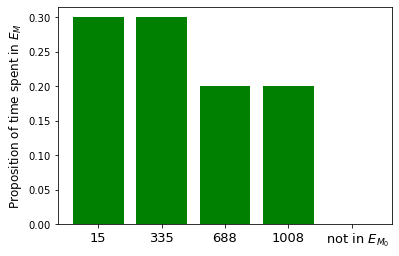

In [10]:
model.histo_time_in_selection_event(states[2000:], ls_states_admissibles,figname='SEISLR-histo.png')

In [27]:
model.M

array([ 2,  3,  5, 12, 13, 22], dtype=int64)

In [21]:
model_size2 = PSILOGIT.PSILOGIT(np.zeros(2), 0.1, n=10)
print('Size of the selection event: ', len(model_size2.M))


Size of the selection event:  2


In [23]:
states, ls_FNR = model_size2.SEI_SLR(total_length_SEISLR_path=50000, backup_start_time=2, random_start=False, conditioning_signs=False)
tildeGN12, barpi = model_size2.params_saturated(model_size2.sig, states2)

ValueError: zero-size array to reduction operation maximum which has no identity

In [8]:
model_size2 = PSILOGIT.PSILOGIT(0*np.ones(5), 1.5, n=20)
print('Size of the selection event: ', len(model_size2.M))

signull = 0.5 * np.ones(model_size2.X.shape[0])

Size of the selection event:  2


In [9]:
def linear_temperature(t):
    return 0.2/np.log(t+1)

states2, ls_FNR, energies = model_size2.SEI_SLR(total_length_SEISLR_path=10000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)
print(len(states2))
statesnull = np.copy(states2)
tildeGN12, barpi = model_size2.params_saturated(signull, statesnull)

7999


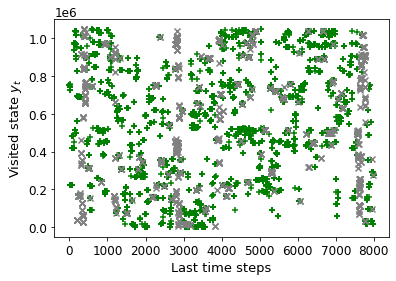

In [10]:
model_size2.last_visited_states(states2, energies=energies)

C:\Users\qduch\OneDrive\Pictures\SIGLE\package\PSILOGIT\Methods\FiguresSigle.py:126: RuntimeWarning: invalid value encountered in true_divide
  sizeout = 9*(sizeout-low)/(up-low)+1
C:\Users\qduch\OneDrive\Pictures\SIGLE\package\PSILOGIT\Methods\FiguresSigle.py:127: RuntimeWarning: invalid value encountered in true_divide
  sizein = 9*(sizein-low)/(up-low)+1


ValueError: cannot convert float NaN to integer

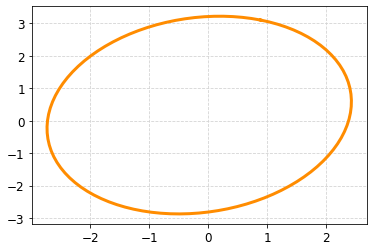

In [11]:
model_size2.ellipse_testing(states2, barpi, alpha=0.05, figname=None, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':5000}, calibrated_from_samples=True, signull=signull, statesnull=statesnull, l2_regularization=100000)

In [142]:
model_size2.X.shape

(15, 5)